<a href="https://colab.research.google.com/github/emm32449/MCTS-in-Python/blob/main/AddingGame_CPU_Pytorch5_with_batches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The game is a simple adding game. The game starts at 0 and players can make moves by adding 1, 2, or 3 to the current state. The goal is to reach exactly 10. If a player’s move results in a state exceeding 10, they receive a negative reward. If the state is less than 10, the reward is based on how close the state is to 10. The game resets once it reaches or exceeds 10.

In [1]:
# Assume we have a simple game state
class GameState:
    def __init__(self, state):
        self.state = state

    def __str__(self):
        return str(self.state)

    def get_legal_moves(self):
        return [1, 2, 3]

    def get_initial_state(self):
        return GameState(0)

    def make_move(self, move):
        return GameState(self.state + move)

    def is_terminal(self):
        return self.state >= 10

    def get_reward(self):
        # Give a positive reward if the state is exactly 10
        if self.state == 10:
            return 1
        # Give a negative reward if the state exceeds 10
        elif self.state > 10:
            return -1
        # Give a reward based on how close the state is to 10
        else:
            return 1 - abs(self.state - 10) / 10

    def reset(self):
        self.state = 0

    def copy(self):
        return GameState(self.state)

    def to_array(self):
        return [self.state]


Alpha Go Zero uses a variant of Monte Carlo Tree Search (MCTS) within its training loop. Starting from the root node, which represents the current game state, it traverses the tree until it reaches a leaf node. This game state is passed through the neural network, which outputs a vector of move probabilities and a scalar estimating the expected outcome. The leaf node is then expanded, with each legal move becoming a new child node. The move probabilities output by the network initialize the prior probabilities of selecting each child node in future simulations. The estimated value output by the network is backpropagated up the tree, updating the value estimates of all nodes along the traversed path.

This process is repeated for many simulations, with the Upper Confidence Bound (UCB) formula guiding the selection of nodes during tree traversal. The UCB formula balances exploration and exploitation, taking into account both the value of the node and the prior probability of the node, as well as the number of times the node has been visited. After a large number of simulations, the move leading to the child node with the highest visit count from the root is selected as the next action. This procedure allows AlphaGo Zero to effectively learn a policy favoring high-value actions and a value function predicting the game outcome.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random
import numpy as np

from torch.nn.utils.rnn import pad_sequence

max_state_value = 15  # Initialize with a known max value or a reasonable estimate

def prepare_data(state):
    global max_state_value
    max_state_value = max(max_state_value, max(state))  # Update the max value if the current state is larger
    normalized_state = [s / max_state_value for s in state]
    return normalized_state

class Node:
    def __init__(self, game_state, policy, parent=None, move=None):
        self.game_state = game_state
        self.policy = policy
        self.parent = parent
        self.move = move
        self.children = []
        self.visits = 0
        self.wins = 0

    def __str__(self):
        return f"GameState: {self.game_state}, Move: {self.move}, Visits: {self.visits}, Wins: {self.wins}"

class MCTS:
    def __init__(self, model, root):
        self.model = model
        self.root = root
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.1)

    def choose_action(self, node):
        # Check the mode of the model
        if self.model.training:
            # If the model is in training mode, use probabilistic action selection
            visit_counts = np.array([child.visits for child in node.children])
            visit_dist = visit_counts / visit_counts.sum()
            chosen_action = node.children[np.random.choice(len(node.children), p=visit_dist)].move
        else:
            # If the model is in evaluation mode, use deterministic action selection
            max_visits = max(child.visits for child in node.children)
            chosen_action = [child.move for child in node.children if child.visits == max_visits][0]
        return chosen_action

    def selection(self, node):
        while len(node.children) > 0:
            max_value = -math.inf
            selected_node = None
            for child in node.children:
                if child.visits == 0:  # Stop if the child node has not been visited yet
                    return child
                state_tensor = torch.tensor(child.game_state.to_array(), dtype=torch.float32)
                policy, value = self.model(state_tensor)
                Q = child.wins / child.visits if child.visits != 0 else 0
                U = policy.mean() * math.sqrt(node.visits) / (1 + child.visits)
                node_value = Q + U + child.policy.mean()  # Take the mean of the policy tensor
                if node_value > max_value:
                    max_value = node_value
                    selected_node = child
            node = selected_node
        return node

    def expansion(self, node):
        # Get the list of legal moves from the game state
        legal_moves = node.game_state.get_legal_moves()

        # For each legal move, create a new node and add it to the children of the current node
        for move in legal_moves:
            new_game_state = node.game_state.make_move(move)
            state_tensor = torch.tensor(new_game_state.to_array(), dtype=torch.float32)
            policy, value = self.model(state_tensor)
            child_node = Node(new_game_state, policy, parent=node, move=move)
            node.children.append(child_node)

        return node.children

    def simulation(self, node):
        game_state = node.game_state.copy()
        while not game_state.is_terminal():
            state_tensor = torch.tensor(game_state.to_array(), dtype=torch.float32)
            policy, _ = self.model(state_tensor)
            policy_dist = F.softmax(policy, dim=0).detach().numpy()
            legal_moves = game_state.get_legal_moves()
            move = np.random.choice(legal_moves, p=policy_dist)
            game_state = game_state.make_move(move)
            print(f"Game state after move: {game_state}")  # Print the game state after each move
        reward = game_state.get_reward()
        print(f"Terminal game state reached with reward: {reward}")  # Print the reward when a terminal state is reached
        return reward

    def backpropagation(self, node, reward):
        # While node is not None
        while node is not None:
            # Update the visit count of the node
            node.visits += 1

            # Update the win count of the node
            node.wins += reward

            # Move to the parent node
            node = node.parent

    def print_tree(self, node, indent=""):
        print(indent + str(node))
        for child in node.children:
            self.print_tree(child, indent + "  ")

    # Train
    '''
    def train(self, states, policies, reward, epochs):
        states = torch.tensor([states], dtype=torch.float32)  # Convert states to tensor and add singleton dimension
        policies = torch.tensor([policies], dtype=torch.float32)  # Convert policies to tensor and add singleton dimension
        reward = torch.tensor([reward], dtype=torch.float32)  # Convert reward to tensor and add singleton dimension

        for _ in range(epochs):
            policy_pred, value_pred = self.model(states)

            policy_loss = F.kl_div(F.log_softmax(policy_pred, dim=1), policies.float())
            # Ensure the tensors are the same shape
            print(value_pred.shape)
            print(reward.shape)
            value_loss = F.mse_loss(value_pred.squeeze(), reward.squeeze())
            loss = policy_loss + value_loss
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return loss.item()
        '''

    def train(self, states, policies, reward, epochs):
        states = torch.tensor([states], dtype=torch.float32)  # Convert states to tensor and add singleton dimension
        policies = torch.tensor([policies], dtype=torch.float32)  # Convert policies to tensor and add singleton dimension
        reward = torch.tensor([reward], dtype=torch.float32)  # Convert reward to tensor and add singleton dimension

        for _ in range(epochs):
            policy_pred, value_pred = self.model(states)

            policy_loss = F.kl_div(F.log_softmax(policy_pred, dim=1), policies.float())
            # Ensure the tensors are the same shape
            print(value_pred.shape)
            print(reward.shape)
            value_pred = value_pred.squeeze()  # This will make value_pred shape as [4]
            reward = reward.expand_as(value_pred)  # This will make reward shape as [4]
            value_loss = F.mse_loss(value_pred, reward)
            loss = policy_loss + value_loss
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return loss.item()

    # Self Play
    def self_play(self, network, game, game_number, num_simulations=25):
        states = []
        policies = []
        current_state = game.get_initial_state()
        root = Node(current_state, None)

        while not current_state.is_terminal():
            for _ in range(num_simulations):
                leaf = self.selection(root)
                children = self.expansion(leaf)
                self.simulation(random.choice(children))
            legal_actions = game.get_legal_moves()
            visit_counts = [child.visits if child.visits > 0 else torch.rand(1).item() for child in root.children]
            policy = torch.zeros(network.policy_head.out_features)  # Initialize a zero vector of length equal to the output size of the policy head
            for action, visit_count in zip(legal_actions, visit_counts):
                policy[action - 1] = visit_count  # Subtract 1 from action to use it as an index
            policy = F.softmax(policy, dim=0)

            action_index = torch.multinomial(policy, 1).item()
            action = root.children[action_index].move
            # states.append(current_state.to_array())
            states.append(prepare_data(current_state.to_array()))
            policies.append(policy.tolist())  # Convert policy tensor to list
            current_state = current_state.make_move(action + 1)  # Add 1 to action to use it as a move
            root = root.children[action_index]

        # Determine the reward based on the final state of the game
        reward = current_state.get_reward()

        return states, policies, reward  # Return policies as a list

Initial Training Loop

In [8]:
# Create the game and network
game = GameState(0)  # Initialize the game
num_actions = len(game.get_legal_moves())  # Get the number of possible actions

network = PolicyValueResNet(num_actions)  # Initialize the policy-value network
uniform_policy = [1.0 / num_actions] * num_actions  # Initialize a uniform policy
root = Node(game.get_initial_state(), uniform_policy)  # Initialize the root node of the MCTS
mcts = MCTS(network, root)  # Initialize the MCTS with the network and root node
losses = []  # Initialize a list to store the losses
network.train()  # Set the network to training mode

epochs = 10  # Define the number of epochs
game_number = 1  # Initialize the game number
optimizer = torch.optim.Adam(network.parameters())  # Initialize the optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)  # Initialize the learning rate scheduler

for i in range(epochs):
    # Run self-play for each game
    states, policies, reward = mcts.self_play(network, game, game_number)
    # Train the model with the collected data
    loss = mcts.train(states, policies, reward, epochs)
    losses.append(loss)
    print(f"Loss after epoch {i+1}: {loss}")
    scheduler.step()
    game_number += 1

Game state after move: 4
Game state after move: 6
Game state after move: 9
Game state after move: 10
Terminal game state reached with reward: 1
Game state after move: 7
Game state after move: 9
Game state after move: 11
Terminal game state reached with reward: -1
Game state after move: 3
Game state after move: 6
Game state after move: 8
Game state after move: 9
Game state after move: 11
Terminal game state reached with reward: -1
Game state after move: 5
Game state after move: 6
Game state after move: 7
Game state after move: 9
Game state after move: 10
Terminal game state reached with reward: 1
Game state after move: 4
Game state after move: 5
Game state after move: 8
Game state after move: 9
Game state after move: 11
Terminal game state reached with reward: -1
Game state after move: 4
Game state after move: 6
Game state after move: 8
Game state after move: 10
Terminal game state reached with reward: 1
Game state after move: 6
Game state after move: 8
Game state after move: 10
Termina

Input is a 1D vector rather than a 2D Board or image. Adjust the network to use fully connected layers (nn.Linear) instead of 2D convolutional layers (nn.Conv2d). The idea behind a Residual Block is to introduce a so-called “skip connection” or “shortcut”, which allows the gradient to be directly backpropagated to earlier layers.

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.fc1 = nn.Linear(num_channels, num_channels)
        self.fc2 = nn.Linear(num_channels, num_channels)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(out)
        out += x  # Skip connection
        out = F.relu(out)
        return out

class PolicyValueResNet(nn.Module):
    def __init__(self, num_actions):
        super().__init__()
        self.hidden1 = nn.Linear(1, 64)
        self.resblock = ResidualBlock(64)
        self.hidden2 = nn.Linear(64, 64)

        # Policy Head forms probabilities for each action, distribution
        self.policy_head = nn.Linear(64, num_actions)

        # Value Head predicts winner of game from each position, scaler
        self.value_head = nn.Linear(64, 1)

    def forward(self, state):
        x = F.relu(self.hidden1(state))
        x = self.resblock(x)
        x = F.relu(self.hidden2(x))
        policy = F.softmax(self.policy_head(x), dim=-1)
        value = torch.tanh(self.value_head(x))
        return policy, value

Torchinfo

In [ ]:
!pip install torchinfo

Multiprocess Games

In [ ]:
'''
from multiprocessing import Pool

def play_game(game_number):
    states, policies, reward = mcts.self_play(network, game, game_number)
    print(f"Game {game_number} completed with {len(states)} states and reward {reward}")
    return states, policies, [reward] * len(states)

pool = Pool(processes=2)  # Create a multiprocessing Pool with 2 workers
for i in range(epochs):
    print(f"Starting epoch {i+1}/{epochs}")
    # results = pool.map(play_game, range(game_number, game_number + batch_size))
    for states, policies, rewards in results:
        print(f"Adding {len(states)} states from game {game_number} to batch")
        batch_states.extend(states)
        batch_policies.extend(policies)
        batch_rewards.extend(rewards)
        game_number += 1
    print(f"Training on batch of {len(batch_states)} states")
    loss = mcts.train(batch_states, batch_policies, batch_rewards, epochs)
    losses.append(loss)
    print(f"Loss after epoch {i+1}: {loss}")
    scheduler.step()
    batch_states, batch_policies, batch_rewards = [], [], []
    '''

Save - AddingGame_MCTS_Model2.pth

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the model, optimizer, game number, and losses
torch.save({
    'model_state_dict': network.state_dict(),
    'optimizer_state_dict': mcts.optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'game_number': game_number,
    'losses': losses
}, '/content/drive/My Drive/MCTS in Python/AddingGame_MCTS_Model2.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load & Continue - AddingGame_MCTS_Model2.pth

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Create the game and network
game = GameState(0)
num_actions = len(game.get_legal_moves())
network = PolicyValueNet(num_actions)

# Load the model, optimizer, game number, and losses
checkpoint = torch.load('/content/drive/My Drive/MCTS in Python/AddingGame_MCTS_Model2.pth')
network.load_state_dict(checkpoint['model_state_dict'])

# Create a uniform policy
uniform_policy = [1.0 / num_actions] * num_actions

root = Node(game.get_initial_state(), uniform_policy)

# Create the MCTS
mcts = MCTS(network, root)
mcts.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
mcts.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

game_number = checkpoint['game_number']
losses = checkpoint['losses']

# Set the model to training mode
network.train()

# Continue training for...<epochs> more games
epochs=2

for _ in range(epochs):
    states, actions, reward = mcts.self_play(network, game, game_number)
    loss = mcts.train(states, actions, reward, epochs)
    losses.append(loss)
    game_number += 1

    # Step the learning rate scheduler
    scheduler.step()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Plot

Average Loss: 0.28465226406955885, Max Loss: 2.0246026515960693, Min Loss: 0.002316388301551342


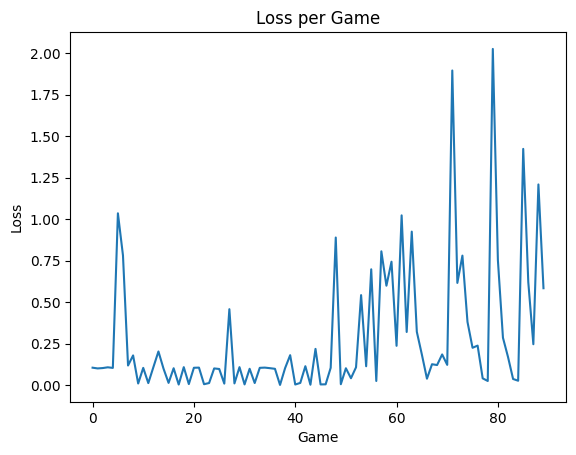

In [ ]:
import matplotlib.pyplot as plt
# Print and plot the losses
print(f"Average Loss: {sum(losses) / len(losses)}, Max Loss: {max(losses)}, Min Loss: {min(losses)}")
plt.plot(losses)
plt.xlabel('Game')
plt.ylabel('Loss')
plt.title('Loss per Game')
plt.show()

Play, Eval() - AddingGame_MCTS_Model2.pth

In [ ]:
# Initialize a list to store the results of each game
win_rates = []

from google.colab import drive
drive.mount('/content/drive')

# See the model playout 10 games using MCTS

# Load the model and optimizer
checkpoint = torch.load('/content/drive/My Drive/MCTS in Python/AddingGame_MCTS_Model2.pth')
network.load_state_dict(checkpoint['model_state_dict'])
mcts.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Set the model to evaluation mode
network.eval()

# Simulate 10 games
num_games = 10

for i in range(num_games):
    print(f"Game {i + 1}:")

    # Initialize the game and the root node
    game_state = game.get_initial_state()
    root = Node(game_state, None)

    #Make sure that the MCTS and the root node persist throughout each game
    mcts = MCTS(network, root)

    while not game_state.is_terminal():
        # Perform MCTS simulations from the root
        for _ in range(num_games):
            leaf = mcts.selection(root)
            children = mcts.expansion(leaf)
            reward = mcts.simulation(random.choice(children))
            mcts.backpropagation(leaf, reward)

        # Choose the action that leads to the most visited child node
        action = mcts.choose_action(root)

        # Apply the action to get the next state
        game_state = game_state.make_move(action)

        print(f"Action taken: {action}")

    print(f"Final reward: {reward}")

    # Append the result of the game to the win_rates list
    # Assume a reward of 1 is a win, 0 is a draw, and -1 is a loss
    win_rates.append(reward)

# mcts.print_tree(mcts.root)

# Calculate the win rate
win_rate = win_rates.count(1) / num_games

# Print and plot the win rates
print(f"Win Rate: {win_rate}")
plt.plot(range(1, num_games + 1), win_rates)
plt.xlabel('Game')
plt.ylabel('Win Rate')
plt.title('Win Rate per Game')
plt.show()